In [2]:
import pandas as pd
import numpy as np

In [3]:
# read in train and test data

meta_train_df = pd.read_csv("review_meta_train.csv")
text_train_df = pd.read_csv("review_text_train.csv")

train_df = pd.concat([text_train_df, meta_train_df], axis=1)

meta_test_df = pd.read_csv("review_meta_test.csv")
text_test_df = pd.read_csv("review_text_test.csv")

test_df = pd.concat([text_test_df, meta_test_df], axis=1)

In [4]:
# assert read in correctly

assert(len(train_df) == 28068)
assert(len(test_df) == 7018)

## EDA metadata

- explore the metadata
- try a zeroR model and try some simple models using only the metadata ( they do not outperform zeroR )

In [87]:
value_counts = train_df['rating'].value_counts()
zeroR_accuracy = value_counts.values.max()/value_counts.sum()
print(zeroR_accuracy)

0.6871882570899245


lets try a quick simple NB model using the voting meta data...

In [103]:
train_df.head()

,review,date,review_id,reviewer_id,business_id,vote_funny,vote_cool,vote_useful,rating
0,dear longman & eagle.......you've left me no c...,3/15/2012,-s77HISu8DVQ8F0HxmWW6A,mthr7h15a_z9m9jRI6mG6Q,m5_GCJP2W4zEJnyVgxa3eA,0,1,3,1
1,Delish. The hubby and I wanted to do brunch on...,6/21/2010,A2aCzGCgg6gAbatHiCrPfA,rhM01fl3iU0xHr3TIpCMhQ,m5_GCJP2W4zEJnyVgxa3eA,0,0,0,5
2,"yep, I've giving Yolk 5 stars. It's just reall...",7/29/2011,DK2pd,SNHKDgmGiLn5chUlhdLCkg,CwPi6NVuJIZZx4IBcTekFQ,1,0,1,5
3,"Meat, meat, meat. It's meat-tastic. So much me...",3/10/2006,b3BkUiWJEKNQko,HXjk1RVfLMPeZxitnk1Auw,43rd1LKcZRIunySzbMsyLQ,17,3,3,3
4,I caught up with the law school girls on a Sat...,8/28/2012,RabHhte,W0ny0BqO0OJ4K4aVnSIlBw,CwPi6NVuJIZZx4IBcTekFQ,0,0,0,3


In [107]:
features = ['vote_funny', 'vote_cool', 'vote_useful']
labels = ['rating']

In [111]:
voting_df = train_df[features + labels].copy()

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [136]:
gnb = GaussianNB()

In [137]:
scores = cross_val_score(gnb, voting_df[features], voting_df['rating'].ravel())
print(scores)

[0.67438546 0.67491984 0.66512291 0.67967219 0.67824693]


this does worse than zeroR, probably there arent enough examples of each particular amount of votes/0 votes is most prevalent so it does about as well as predicting the most common class. lets try transforming each number of votes to a percentage of total votes and see how it does...

In [139]:
voting_df['total_votes'] = voting_df['vote_funny'] + voting_df['vote_cool'] + voting_df['vote_useful']

In [142]:
for feature in features:
    feature_percentage = feature + "_percentage"
    voting_df[feature_percentage] = voting_df[feature]/voting_df['total_votes']

In [144]:
voting_df.head()

,vote_funny,vote_cool,vote_useful,rating,total_votes,vote_funny_percentage,vote_cool_percentage,vote_useful_percentage
0,0,1,3,1,4,0.00000,0.250000,0.750000
1,0,0,0,5,0,NaN,NaN,NaN
2,1,0,1,5,2,0.50000,0.000000,0.500000
3,17,3,3,3,23,0.73913,0.130435,0.130435
4,0,0,0,3,0,NaN,NaN,NaN


In [148]:
new_features = [feature + "_percentage" for feature in features]

In [155]:
voting_df[new_features] = voting_df[new_features].fillna("0")

In [156]:
scores = cross_val_score(gnb, voting_df[new_features], voting_df['rating'].ravel())
print(scores)

[0.67901674 0.67581047 0.67687923 0.67610903 0.67575272]


GNB is probably not the correct model to use on this data as P(percentage_funny) * P(percentage_cool) != P(percentage_funny and percentage_cool)...

maybe we can try a tree based model to see if the meta data is helpful in classification... this will also deal better with the nan values...

In [157]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
clf = RandomForestClassifier()

In [178]:
scores = cross_val_score(clf, voting_df[new_features], voting_df['rating'].ravel(), cv = 5)
print(scores)

[0.68721055 0.68578554 0.69006056 0.68537324 0.68608587]


random forest provides a similar performance... using the meta data alone seems to be no good!

## EDA

lets try classifying based on net sentiment...

sentiment lexicon

http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html

In [636]:
lexicon = pd.read_csv("AFINN/AFINN-111.txt", header = None)
lexicon['word'] = lexicon[0].apply(lambda x: x.split("\t")[0])
lexicon['sentiment'] = lexicon[0].apply(lambda x: x.split("\t")[1])
lexicon = lexicon.drop(0, axis = 1)
lexicon['sentiment'] = pd.to_numeric(lexicon['sentiment'])

In [637]:
lexicon

,word,sentiment
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
...,...,...
2472,yucky,-2
2473,yummy,3
2474,zealot,-2
2475,zealots,-2


In [285]:
import re

In [638]:
import re
def get_sentiment(txt, lexicon = lexicon):
    s = txt.lower()
    words = re.sub(r'[^\w\s]|(\n)','',s).split(" ")
    words_df = pd.DataFrame(data = {"word": words})
    words_df = words_df.merge(lexicon, how = "left", on = "word").fillna(0)
    sentiment = words_df['sentiment'].sum()
    return sentiment

In [343]:
get_sentiment(train_df.review[0], lexicon)

6.0

In [350]:
sentiment = list(map(get_sentiment, X_train_txt.tolist()))

In [353]:
from sklearn.linear_model import LogisticRegression

In [376]:
X_train, X_test, y_train, y_test = train_test_split(np.array(sentiment).reshape(-1, 1), train_df['rating'].ravel().reshape(-1, 1), train_size = 0.8, random_state = 0)

In [396]:
clf = RandomForestClassifier()

In [394]:
clf =  RandomForestClassifier().fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [395]:
pd.Series(clf.predict(X_test)).value_counts()

5    5301
1     309
3       4
dtype: int64

In [397]:
cross_val_score(clf, np.array(sentiment).reshape(-1, 1), train_df['rating'].ravel().reshape(-1, 1), cv = 5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

array([0.70555753, 0.70502316, 0.70751692, 0.70586139, 0.70550508])

In [399]:
train_df['rating'].ravel().reshape(-1, 1)

array([[1],
       [5],
       [5],
       ...,
       [5],
       [5],
       [5]], dtype=int64)

class labels are quite unbalanced. the models might be getting lazy and simply picking the majority class most of the time.
what can we do about this? 
lets try building some samples with balanced classes using bootstrapping for example...

In [431]:
X_train, X_test, y_train, y_test = train_test_split(np.array(sentiment).reshape(-1, 1), train_df['rating'].ravel().reshape(-1, 1), train_size = 0.8, random_state = 0)

In [414]:
from imblearn.under_sampling import RandomUnderSampler

In [421]:
rus = RandomUnderSampler()

In [433]:
X_rus, y_rus = rus.fit_sample(X_train, y_train)

In [443]:
clf = RandomForestClassifier().fit(X_rus, y_rus)

In [444]:
clf.score(X_test, y_test)

0.46954043462771644

In [446]:
train_df['sentiment'] = sentiment

In [447]:
import matplotlib.pyplot as plt

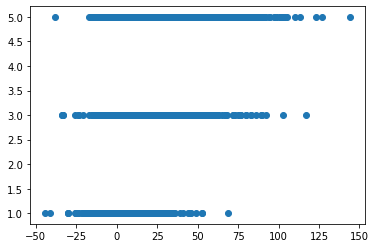

In [449]:
plt.scatter(train_df.sentiment, train_df.rating)

In [450]:
train_df.groupby(['rating'])['sentiment'].mean()

rating
1     1.771404
3    11.965860
5    14.933171
Name: sentiment, dtype: float64

the 1 ratings have a super low sentiment so why the fuck arent my classifiers doing a good job!?!?

In [451]:
from sklearn.cluster import KMeans

In [577]:
# clf = KMeans(n_clusters = 3, n_init = 100, max_iter = 100000, verbose = 1)
# clf.fit(train_df.sentiment.ravel().reshape(-1, 1))
# clf.fit(train_df.sentiment.ravel().reshape(-1, 1))
# clusters = clf.labels_
# clf.cluster_centers_
# pd.Series(clf.labels_).value_counts()
# train_df['clusters'] = clusters
# train_df['clusters'] = train_df['clusters'].replace({0: 1, 1: 3, 2: 5})

In [580]:
voting_df['sentiment'] = sentiment

In [637]:
features = ['vote_funny', 'vote_cool', 'vote_useful', 'sentiment']

In [638]:
features = ['sentiment']

In [646]:
txt = train_df.review[20]

In [662]:
train_df.review[20]

'The Good: -The absolute BEST deep dish pizza I have EVER had! -Great service (waiters/waitresses are fun and friendly) -Recommended by more Chicagoans I know than any other place when asked where to go for the BEST pizza The Bad: -None The Ugly: -Friend told me he had food poisoning from them once, to give you an idea of how good the pizza is, he still goes there regularly!\n'

In [650]:
s = txt.lower()

In [688]:
def get_first_and_last_sentiment(txt, lexicon = lexicon):
    s = txt.lower()
    words = re.sub(r'[^\w\s]|(\n)','',s).split(" ")
    words_df = pd.DataFrame(data = {"word": words})
    words_df = words_df.merge(lexicon, how = "left", on = "word").fillna(0)
    cutoff = round(len(words)/10)
    first_sentiment = words_df[:cutoff].sentiment.sum()
    last_sentiment = words_df[-cutoff:].sentiment.sum()
    return first_sentiment, last_sentiment

In [699]:
first_and_last_sentiment = list(map(get_first_and_last_sentiment, train_df.review.tolist()))

In [700]:
first_sentiment = list(map(lambda x: x[0], first_and_last_sentiment))
last_sentiment = list(map(lambda x: x[1], first_and_last_sentiment))

In [701]:
train_df['first_sentiment'] = first_sentiment
train_df['last_sentiment'] = last_sentiment

In [789]:
features = ['sentiment', 'first_sentiment', 'last_sentiment']

In [790]:
train_df['elipsis'] = train_df['elipsis'].astype("category")

In [791]:
X_train, X_test, y_train, y_test = train_test_split(np.array(train_df[features]), train_df['rating'].ravel(), train_size = 0.8, random_state = 0)

In [792]:
clf = RandomForestClassifier()

In [793]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [666]:
import xgboost as xgb
from xgboost import XGBClassifier

In [674]:
classif = XGBClassifier(nrounds = 500)

In [676]:
classif.fit(X_train, y_train)

[15:31:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, nrounds=500, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [668]:
?XGBClassifier

In [670]:
classif.train(num_boost_round = 500)

AttributeError: 'XGBClassifier' object has no attribute 'train'

In [311]:
X_train_txt = train_df.review
X_test_txt = test_df.review
vectoriser = CountVectorizer()
X_train = vectoriser.fit_transform(X_train_txt)
y_train = np.array(train_df.rating)

In [312]:
X_train

<28068x41952 sparse matrix of type '<class 'numpy.int64'>'
	with 2394320 stored elements in Compressed Sparse Row format>

In [313]:
clf = MultinomialNB()

In [272]:
cross_val_score(clf, X_train, y_train)

array([0.84307089, 0.84467403, 0.8519772 , 0.84714057, 0.84429004])

In [314]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [315]:
clf.score(X_train, y_train)

0.8942924326635314

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.sparse import hstack

In [188]:
X_train_txt = train_df.review
X_test_txt = test_df.review

In [189]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
adc = AdaBoostClassifier()
rfc = RandomForestClassifier()
nbc = MultinomialNB()

In [194]:
vectoriser = CountVectorizer(ngram_range=(1, 1))
X_train = vectoriser.fit_transform(X_train_txt)
y_train = np.array(train_df.rating)

In [197]:
nbc.fit(X_train, train_df.rating.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [200]:
nbc.score(X_train, train_df.rating.ravel())

0.8942924326635314

In [155]:
X_train_txt

0        dear longman & eagle.......you've left me no c...
1        Delish. The hubby and I wanted to do brunch on...
2        yep, I've giving Yolk 5 stars. It's just reall...
3        Meat, meat, meat. It's meat-tastic. So much me...
4        I caught up with the law school girls on a Sat...
                               ...                        
28063    This afternoon I went to Yolk with my college ...
28064    Place has lots of side dishes. But that's abou...
28065    I am a huge fan of Brazillian steakhouses I've...
28066                                      Great Brunch.\n
28067    I love The Chicago Diner. I first came here ab...
Name: review, Length: 28068, dtype: object

In [247]:
X_train

<22455x37960 sparse matrix of type '<class 'numpy.int64'>'
	with 1918807 stored elements in Compressed Sparse Row format>

In [137]:
from sklearn.naive_bayes import GaussianNB

In [130]:
vectoriser = CountVectorizer(ngram_range=(1, 1))

In [73]:
from sklearn.utils import shuffle

In [207]:
train = shuffle(train_df[['rating', 'review']], random_state = 0)
folds = np.array_split(train, 5)

In [316]:
folds = np.array_split(train, 5)

In [317]:
folds[0]

,rating,review
11031,5,Came in on a Saturday night before catching a ...
10977,5,Love your hot dogs Doug.Thanks for the great f...
13996,3,Arg! I gotta get this out of the way right fro...
3668,5,"Last year, I did a pho quest to a whole slew o..."
6969,5,This place is amazing--for BRUNCH. I've come o...
...,...,...
16939,5,Me likey the macaroons and dah coffee. Goooood...
28000,1,What a horrible place!! Going there was a very...
573,5,AMAAAAAAZING! I have never been to a fondue re...
23051,5,Absolutely loved this place! **Warning - do n...


In [318]:
fold_n = 3

In [319]:
train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
train_fold = pd.concat(train_folds, axis = 0)
test_fold = folds[fold_n]

In [320]:
train_fold = pd.concat(train_folds, axis = 0)
test_fold = folds[fold_n]

In [321]:
train_fold.review

11031    Came in on a Saturday night before catching a ...
10977    Love your hot dogs Doug.Thanks for the great f...
13996    Arg! I gotta get this out of the way right fro...
3668     Last year, I did a pho quest to a whole slew o...
6969     This place is amazing--for BRUNCH. I've come o...
                               ...                        
13123    Ruth's Chris is an excellent steak house, in t...
19648    I returned with my dad, and had an incredibly ...
9845     Every time I visit Chicago, I try to visit the...
10799    Bonsoiree is fabulous! We had the 8 course men...
2732     Third time here, although this place is good, ...
Name: review, Length: 22455, dtype: object

In [377]:
X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])

In [378]:
vectoriser = CountVectorizer()
vectoriser.fit(X_train_txt)
X_train = vectoriser.transform(X_train_txt)
X_test = vectoriser.transform(X_test_txt)

In [399]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [403]:
classifiers = {
    "multinomial_naive_bayes": MultinomialNB(),
    "random_forest_classifier": RandomForestClassifier(),
    "adaboost_classifier": AdaBoostClassifier(),
    "logistic_regression": LogisticRegression()
}

In [404]:
for classifier in list(classifiers.keys()):
    
    clf = classifiers[classifier]
    
    test_scores = []
    
    for fold_n in range(5):

        train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
        train_fold = pd.concat(train_folds, axis = 0)
        test_fold = folds[fold_n]

        X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
        X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])

        vectoriser.fit(X_train_txt)
        X_train = vectoriser.transform(X_train_txt)
        X_test = vectoriser.transform(X_test_txt)

        before = time.time()
        clf.fit(X_train, y_train)
        after = time.time()
        train_time = after - before

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        test_scores.append(test_score)
        
        print(
            '''
            {} took {:.2f} seconds to train
            and has training accuracy {:.3f} and testing accuracy {:.3f}
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            '''.format(classifier, train_time, train_score, test_score)
        )
    
    mean_test_score = np.mean(test_scores)
    
    print("the mean test score for {} was {:.3f}".format(classifier, mean_test_score))
    


            multinomial_naive_bayes took 0.01 seconds to train
            and has training accuracy 0.897 and testing accuracy 0.849
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            multinomial_naive_bayes took 0.01 seconds to train
            and has training accuracy 0.899 and testing accuracy 0.844
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            multinomial_naive_bayes took 0.01 seconds to train
            and has training accuracy 0.899 and testing accuracy 0.852
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            multinomial_naive_bayes took 0.01 seconds to train
            and has training accuracy 0.900 and testing accuracy 0.852
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            multinomial_naive_bayes took 0.02 seconds to train
            and has training accurac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            logistic_regression took 3.00 seconds to train
            and has training accuracy 0.950 and testing accuracy 0.861
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            logistic_regression took 2.93 seconds to train
            and has training accuracy 0.948 and testing accuracy 0.858
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            logistic_regression took 2.82 seconds to train
            and has training accuracy 0.949 and testing accuracy 0.857
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



            logistic_regression took 2.93 seconds to train
            and has training accuracy 0.950 and testing accuracy 0.855
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            

            logistic_regression took 2.98 seconds to train
            and has training accuracy 0.954 and testing accuracy 0.859
            - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            
the mean test score for logistic_regression was 0.858


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Looks like both the random forest classifier and logistic regression are severely overfitting. Lets play around with some different parameters to see if we can get the models to do a bit better...

In [405]:
from sklearn.model_selection import GridSearchCV

In [435]:
grid_values = {'C': [0.01,0.1,1,10,100,1000]}
clf = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(clf, grid_values)
grid_search.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [442]:
pd.DataFrame(data = grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.640097,0.080018,0.003002,3.742488e-06,0.01,{'C': 0.01},0.849922,0.853039,0.845469,0.843242,0.848586,0.848052,0.003420,3
1,9.917177,0.897295,0.003000,1.784161e-07,0.1,{'C': 0.1},0.861501,0.863059,0.855934,0.855711,0.861501,0.859541,0.003090,1
2,18.865662,0.889156,0.003000,1.784161e-07,1,{'C': 1},0.855043,0.860165,0.847473,0.852149,0.856602,0.854286,0.004278,2
3,25.019686,0.285765,0.003000,7.629395e-07,10,{'C': 10},0.843687,0.854153,0.843465,0.844578,0.840125,0.845202,0.004724,4
4,24.858453,0.154306,0.003198,3.958702e-04,100,{'C': 100},0.832331,0.842797,0.831663,0.828991,0.829659,0.833088,0.005008,5
5,24.573138,0.088159,0.003000,1.784161e-07,1000,{'C': 1000},0.824093,0.835894,0.822089,0.820753,0.828991,0.826364,0.005525,6


looks like for logistic regression 0.1 is the best regularization parameter... this doenst really do that much better than the default parameter of 1 though.

In [444]:
?RandomForestClassifier

In [447]:
clf = RandomForestClassifier()

In [450]:
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 50, 100]
}

In [451]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [452]:
pd.DataFrame(data = grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.094977,0.018735,0.111506,0.002153,10,auto,"{'max_depth': 10, 'max_features': 'auto'}",0.688265,0.688043,0.688043,0.688043,0.688043,0.688087,0.000089,7
1,3.129536,0.038128,0.111973,0.001764,10,sqrt,"{'max_depth': 10, 'max_features': 'sqrt'}",0.688265,0.688265,0.688043,0.688043,0.688043,0.688132,0.000109,6
2,0.921014,0.025196,0.106161,0.000823,10,log2,"{'max_depth': 10, 'max_features': 'log2'}",0.688043,0.688043,0.688043,0.688043,0.688043,0.688043,0.000000,8
3,20.318649,0.261314,0.168525,0.008842,50,auto,"{'max_depth': 50, 'max_features': 'auto'}",0.716099,0.719662,0.712314,0.713204,0.716322,0.715520,0.002599,4
4,20.145186,0.259849,0.164552,0.001706,50,sqrt,"{'max_depth': 50, 'max_features': 'sqrt'}",0.716990,0.714540,0.716544,0.717435,0.712982,0.715698,0.001681,3
5,4.750251,0.088108,0.153628,0.001275,50,log2,"{'max_depth': 50, 'max_features': 'log2'}",0.688043,0.688043,0.688043,0.688043,0.688043,0.688043,0.000000,8
6,30.398458,0.156999,0.191634,0.007207,100,auto,"{'max_depth': 100, 'max_features': 'auto'}",0.729014,0.725674,0.723670,0.720330,0.725006,0.724738,0.002821,2
7,30.436250,0.209925,0.189154,0.002122,100,sqrt,"{'max_depth': 100, 'max_features': 'sqrt'}",0.727678,0.725228,0.725896,0.725896,0.726787,0.726297,0.000850,1
8,10.086935,0.052781,0.200188,0.002294,100,log2,"{'max_depth': 100, 'max_features': 'log2'}",0.688711,0.689156,0.688488,0.688933,0.689156,0.688889,0.000260,5


looks like parameter tuning for randomforest also doesnt make a huge difference. Also bear in mind tree based algorithms are prone to overfit the training data. it's not a huge problem if i cant eek out better performance. is this a question of the grid representation???

cool, lets try stacking models and seeing if they perform any better!

In [ ]:
classifiers = {
    "multinomial_naive_bayes": MultinomialNB(),
    "random_forest_classifier": RandomForestClassifier(max_depth = 50),
    "adaboost_classifier": AdaBoostClassifier(),
    "logistic_regression": LogisticRegression(C = 0.01)
}


    
    for fold_n in range(5):

        train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
        train_fold = pd.concat(train_folds, axis = 0)
        test_fold = folds[fold_n]

        X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
        X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])

        vectoriser.fit(X_train_txt)
        X_train = vectoriser.transform(X_train_txt)
        X_test = vectoriser.transform(X_test_txt)
        
        before = time.time()
        
        predictions_list = []
        
        for classifier in list(classifiers.keys()):
            
            clf = classifiers[classifier]
        
            clf.fit(X_train, y_train)
            
            predictions = clf.predict(X_test)
            
            predictions_list.append(predictions)
        
        after = time.time()
        
        train_time = after - before
        
        meta_classifier = LogisticRegression()
        
        
        
        train_score = clf.score(X_train, y_train)
            test_score = clf.score(X_test, y_test)

            test_scores.append(test_score)
        
        print(train_time)

            print(
                '''
                {} took {:.2f} seconds to train
                and has training accuracy {:.3f} and testing accuracy {:.3f}
                - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                '''.format(classifier, train_time, train_score, test_score)
            )
    
    mean_test_score = np.mean(test_scores)
    
    print("the mean test score for {} was {:.3f}".format(classifier, mean_test_score))
    

In [536]:
clfs = []

In [556]:

vectoriser.fit(X_train_txt)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [635]:
test_df

,review,date,review_id,reviewer_id,business_id,vote_funny,vote_cool,vote_useful
0,It is 10am on a Monday morning and my wife say...,10/17/2011,WwAdD9wjkLqZHOO5,CY9iLsE2z_yLhLqJdD1WGw,cQnY_VneZisfUAqcbuEuKg,2,1,3
1,I came here with a friend for her work thing -...,3/19/2007,Rd-Vra4drjDI8AQCXf6yTA,6feRQ3I9RpxRlEX7gPuJRg,sfWMOqUEp8S2adDeJp7Kzg,0,1,3
2,ATTENTION!!! DO NOT GO TO THIS RESTAURANT EVER...,12/27/2008,mJD,RQs0smGxdXIlBqqlNP7pNg,2WoMT3wSpp9vxZeTv6u-cw,0,0,0
3,"I agree, with Jonathan S. - this place is a 3....",6/1/2010,J-xkladMPiVZFVhIbXLNEQ,q6EF83uL2lFRtnWwrfaYGA,AqgG-1aD6JYj9D6OmBWO3w,0,0,0
4,"First visit to Chicago, and a friend recommend...",9/4/2012,jOMycoLCy79-256vNxl1kA,erZZ9K9wgdSswAm6TEh7Qw,boE4Ahsssqic7o5wQLI04w,0,0,0
...,...,...,...,...,...,...,...,...
7013,I LOVED XOCO! It was amazing! My friends and I...,1/22/2010,QcCptbqQUgYwqeKz6Roncg,wISjGJS3bb6dh1rs2f1c1Q,jGiKIJCVLZHXQDSNnSLPsw,0,0,0
7014,Place is pretty dark. A place to chat with a g...,6/14/2012,LG3FrYu03BCqQ-TAGsbowA,0eoCRbkKsEj8iv2Aow2ong,oEFJ29zAQaCNnQzebHQvpg,2,0,0
7015,Get to Xoco and you can order yourself a tasty...,5/10/2010,Y2IKY1Nbmt2rjbiVyJoSSg,eiMZGw1zY8xwk1Xc3GM8lw,jGiKIJCVLZHXQDSNnSLPsw,0,0,1
7016,I'm writing this less than 10 minutes after re...,6/9/2011,OrKMrbD8J2J-0jLPip6ifA,L80nu6pXxl07zb_IKn0ZLw,UQ3cGi3GdBljE3i2_qLcBQ,3,0,4


In [599]:
meta_train, meta_test = train_test_split(train_df[['rating', 'review']])

In [600]:
meta_test

,rating,review
12288,5,Great beer selection. Tasty moules. What else ...
4665,5,I love love love Pequods! Great pan pizza in f...
6170,5,Where else can you eat veal heart while the Co...
20097,5,"I'm somewhat of a gastropub junkie, and as suc..."
20763,5,"Alinea, oh yes. I would go here every week if ..."
...,...,...
25628,5,I give 5 star reviews to places I would eat at...
13519,5,"i say goddamn! when it comes to sushi rolls, i..."
2396,3,"There is no doubt about it, this place has goo..."
27958,5,Great place. I recently heard of this place an...


In [643]:
sentiment = list(map(get_sentiment, X_test_txt))


In [ ]:
XGBClassifier(nrounds = 500)

In [677]:
vectoriser = CountVectorizer(ngram_range=(1, 2))

scores = []

classifiers = {
    "multinomial_naive_bayes": MultinomialNB(),
    "random_forest_classifier": RandomForestClassifier(max_depth = 50),
    "adaboost_classifier": AdaBoostClassifier(),
    "logistic_regression": LogisticRegression(C = 0.01, max_iter=1000),
    "xgboost": XGBClassifier(nrounds = 500)
}

# loop


for fold_n in range(5):
    
    print(fold_n)
    
    meta_train, meta_test = train_test_split(train_df[['rating', 'review']])
    
    train = shuffle(meta_train)
    
    folds = np.array_split(train, 5)

    train_folds = [folds[i] for i in range(len(folds)) if i != fold_n]
    train_fold = pd.concat(train_folds, axis = 0)
    test_fold = folds[fold_n]

    X_train_txt, y_train = train_fold["review"], np.array(train_fold["rating"])
    X_test_txt, y_test = test_fold["review"], np.array(test_fold["rating"])

    vectoriser.fit(X_train_txt)
    X_train = vectoriser.transform(X_train_txt)
    X_test = vectoriser.transform(X_test_txt)

    before = time.time()
    
    clfs = []
    
    predictions_list = []
    
    for classifier in list(classifiers.keys()):

        clf = classifiers[classifier]

        clfs.append(clf)

        clf.fit(X_train, y_train)

        score = clf.score(X_test, y_test)

        print("{} accuracy {}".format(classifier, score))

        predictions = clf.predict(X_test)

        predictions_list.append(predictions)

    after = time.time()

    print(after - before)

    meta_clf = RandomForestClassifier()

    meta_clf.fit(np.stack(predictions_list).transpose(), y_test)

    # lets test the meta classifier on the meta test data

    reviews = vectoriser.transform(meta_test.review)

    new_predictions = []

    for clf in clfs:
        predictions = clf.predict(reviews)
        new_predictions.append(predictions)

    score = meta_clf.score(np.stack(new_predictions).transpose(), meta_test.rating)

    scores.append(score)

    print("stacking accuracy is {}".format(score))

0
multinomial_naive_bayes accuracy 0.7513654713844693
random_forest_classifier accuracy 0.7048207076703871
adaboost_classifier accuracy 0.8000474946568511
logistic_regression accuracy 0.8658275943956305
[15:45:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


xgboost accuracy 0.8639278081215863
83.33362364768982
stacking accuracy is 0.8693173720963374
1
multinomial_naive_bayes accuracy 0.7396674584323041
random_forest_classifier accuracy 0.694061757719715
adaboost_classifier accuracy 0.7971496437054632
logistic_regression accuracy 0.856769596199525
[15:47:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n

performs worse when adding some sort of sentiment

In [680]:
np.mean(scores)

0.8710845090494514

interestingly the performance of each individual classifier gets worse, but when i stack them the performance is better!!!

performs slightly better than the individual classifiers...

lets train one on the whole set and then try it on Kaggle!!!

In [681]:
classifiers = {
    "multinomial_naive_bayes": MultinomialNB(),
    "random_forest_classifier": RandomForestClassifier(max_depth = 50),
    "adaboost_classifier": AdaBoostClassifier(),
    "logistic_regression": LogisticRegression(C = 0.01, max_iter = 1000),
    "xgboost": XGBClassifier(nrounds = 500)
}

# loop
    
meta_train, meta_test = train_test_split(train_df[['rating', 'review']])

train = shuffle(meta_train)

vectoriser.fit(meta_train.review)
X_train = vectoriser.transform(meta_train.review)
y_train = meta_train.rating

X_test = vectoriser.transform(meta_test.review)
y_test = meta_test.rating

clfs = []

predictions_list = []
    
for classifier in list(classifiers.keys()):

    clf = classifiers[classifier]

    clfs.append(clf)

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)

    predictions_list.append(predictions)

meta_clf = RandomForestClassifier()

meta_clf.fit(np.stack(predictions_list).transpose(), y_test)

[15:55:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [682]:
X_test = vectoriser.transform(test_df.review)

predictions_list = []
    
for classifier in list(classifiers.keys()):

    clf = classifiers[classifier]

    predictions = clf.predict(X_test)

    predictions_list.append(predictions)

In [683]:
predictions = meta_clf.predict(np.stack(predictions_list).transpose())

In [684]:
predictions

array([5, 5, 1, ..., 5, 5, 5], dtype=int64)

In [685]:
predictions_df = pd.DataFrame(list(enumerate(predictions, start = 1)))

In [686]:
predictions_df = predictions_df.rename(columns = {0: 'instance_id', 1: 'rating'})

In [687]:
predictions_df.to_csv("predictions_3.csv", index = False)

In [688]:
predictions_df

,instance_id,rating
0,1,5
1,2,5
2,3,1
3,4,3
4,5,5
...,...,...
7013,7014,5
7014,7015,5
7015,7016,5
7016,7017,5


In [ ]:
enumerate(start = 1)